# Lab 2: Bag of Visual Words Image Classification

Team 3: Zuzanna Szafranowska, Claudia Baca, Quim Comas

In [27]:
import cv2
import numpy as np
import itertools
#inPython3.x:
import pickle as cPickle
#in Python2.x:
#import cPickle
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
# from sklearn.cross_validation import StratifiedKFold



Let us first read the train and test files

In [28]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))

<h1>Feature extraction, descriptors</h1>
We create detectors and descriptors: SIFT, SURF, ORB

In [29]:
SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=300)
SURFdetector = cv2.xfeatures2d.SURF_create(300)
ORBdetector = cv2.ORB_create()

We choose the type of local feature detector that we want to use. 

- 1 ==> SIFT
- 2 ==> SURF
- 3 ==> ORB
- 4 ==> Dense SIFT
- 5 ==> Dense SURF


In [30]:
x=4
#x = input("Enter a number to choose the local feature detector: ")
L=2
#Enter the number levels of the spatial pyramid (O to L)
norm=1
#Type of normalization of 1 L2 and 2 Power

In [31]:
def descriptors(gray,x):
    if(x==1):
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
    if(x==2):
        kpt,des=SURFdetector.detectAndCompute(gray,None)
    if(x==3):
        kpt,des=ORBdetector.detectAndCompute(gray,None)
    if(x==4):
        step_size = 5
        kpt = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                            for x in range(0, gray.shape[1], step_size)]
        kpt,des=SIFTdetector.compute(gray,kpt)
    if(x==5):
        step_size = 5
        kpt = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                            for x in range(0, gray.shape[1], step_size)]
        kpt,des=SURFdetector.compute(gray,kpt)
    return kpt, des

In [ ]:
def normalize(hist1):
    if(norm==1):
        hist2=np.linalg.norm(x, ord=2)
        normhist=hist1 / hist2
    if(norm==2):
        hist=np.linalg.norm(x, ord=2)
return normhist       

<h1>BOW</h1>
We compute the indicated descriptor for all the train images and subsequently build a numpy array with all the descriptors stacked together, then we   compute a k-means clustering on the descriptor space, where we test 3 different codebook sizes k (64,128,256). And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [71]:
def Bow(train_images_filenames,train_labels):
    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        
        kpt,des=descriptors(gray,x)
        
        Train_descriptors.append(des)
        
        Train_label_per_descriptor.append(labels)
    D=np.vstack(Train_descriptors)
    k = 256
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)
    
    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)): 
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)
    
    return visual_words
    
    
    

In [72]:
visual_words=Bow(train_images_filenames,train_labels)

<h1>Bow-Spatial Pyramid</h1>
We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [79]:
def get_spatialpyramid(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        i=0;
        Train_label_per_descriptor.append(labels)
        
        for l in range(L+1):
            if(l==0):
                kpt,des=descriptors(gray,x)
                codebook.fit((des))
                words = codebook.predict((des))
                visualwords = np.bincount(words, minlength=k).reshape(1,-1).ravel()
                print(words)
                hist.append(visualwords)
        
            else:
                print (l)
                wstep=np.int(gray.shape[0]/(2*l))
                hstep=np.int(gray.shape[1]/(2*l))
                
                for u in range(0,gray.shape[0],wstep):
                    for f in range(0,gray.shape[1],hstep):  
                        kpt,des=descriptors(gray[f:f+hstep, u:u+wstep],x)
                        words = codebook.predict((des))
                        visualwords = np.bincount(words, minlength=k).reshape(1,-1).ravel()
                        weight = 2**(L-l)
                        
                        print(visualwords)
                        hist.append(weight*visualwords)     
return hist
                        

In [81]:
Train_descriptors = []
Train_label_per_descriptor = []
visual_words=list
hist=[]
k = 256
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)

for filename,labels in zip(train_images_filenames,train_labels):
    
    hist=get_spatialpyramid(train_images_filenames,train_labels);
        
    visual_words=(hist)
    
        
            

[120 120  78 ... 186 186 186]
1
[ 0  0  0  0  3  8  0  2  6  0  0  7 14  4  7  9  5  0  0  1  0  7  8  1
 23  5  0  0  0  0  1  2  0  1  7  1  6  0  0  0  0  1 18 15  3  5  3  0
  0 10  0  7  0  0  0  0  8  0  4  5  0  6  7  0  0 13  2  2  6  0  3  0
  6  4 16  0  7  1  5  0  0  0  4  2  9  0  0  5  2  4  1  0  2  0  5  0
  0  0  6  5  0  8  0  5  2  1  0  0  0  0  0  0  9  3  5  0  0  0  4  0
  9  2  0 13  3  0 10  8  0  0  8  8  2  0  0  2  0  0  0  0  0  1 10  8
  2  0  1  0  0  5 11 15  5  0  1  1  7  0  1  1  0  6  0  0  5  0  2  1
  6  0  0  2  0  0  0  0  4  0  0  2 10  2  0  1  0  5  0  0  0  5 12  7
  9  0  0  2  1  4  1  4  0  0  9  0  1  0  1  0  0  0  0  5  0  0  0  1
  0  0  0  0  5  4  0  3  0  0  5  5  0  4  0  0  7  2  1  3  0  0  0  0
  0  0  0  0  0  0  0  6  0  4  2  2  2  6  4  2]
[ 3  4  8  6  1  3  7  0  6 12  0  3  0  0  0  7  0  0  7 11  0  0 10  0
  0  7  0 20  0  7  4  0  0 17  0  6  3  0  1  3  0  0  0  0  0  1  7  0
 13  0  6  0 22  0  5  0  0  1  0  6  8  0

[ 40  31  31 ... 193 120 120]


AttributeError: 'NoneType' object has no attribute 'append'

Before applying the SVM we create the histogram intersection kernel (it is not available in the sklearn library):

In [80]:
def histogram_intersection(M,N):
    M_samples, M_features = M.shape
    N_samples, N_features = N.shape
    
    K_int= np.zeros(shape=(M_samples,N_samples),dtype= np.float)
    for i in range(M_samples):
        for j in range(N_samples):
            K_int[i,j]=np.minimum(M[i,:],N[j,:]).sum()
    
    return K_int

<h1>SVM kernels</h1>
In this step we add the SVM classifier to train our data. Before train our visual words, we preprocess the data standardizing the features by removing the mean and scaling to unit variance. In our implementation we can choose between different types of kernels:

- Linear Kernel --> 'linear'
- Rbf Kernel --> 'rbf'
- Polynomial Kernel --> 'poly'
- Sigmoid Kernel --> 'sigmoid'
- Histogram Intersection Kernel --> 'histogram'

In [36]:
#Choose the type of kernel (histogram by default):

Kernel= 'histogram'

K_cv=3
folds = list(StratifiedKFold(n_splits=K_cv, shuffle=True, random_state=16).split(visual_words, train_labels))
for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)

    visual_words_train = visual_words[train_idx]
    train_labels=np.asarray(train_labels)
    labels_train = train_labels[train_idx]
    visual_words_valid = visual_words[test_idx]
    labels_valid= train_labels[test_idx]

    stdSlr_valid= StandardScaler().fit(visual_words_valid)
    scaler_valid= stdSlr_valid.transform(visual_words_valid)
    stdSlr_train= StandardScaler().fit(visual_words_train)
    scaler_train= stdSlr_train.transform(visual_words_train)
    stdSlr= StandardScaler().fit(visual_words)
    scaler = stdSlr.transform(visual_words)

    if(Kernel=='linear'):
        clf= svm.SVC(kernel='linear',C=1,gamma=0.002).fit(scaler_train,labels_train)
    if(Kernel=='rbf'):
        clf= svm.SVC(kernel='rbf',C=1,gamma=0.002).fit(scaler_train,labels_train)
    if(Kernel=='poly'):
        clf= svm.SVC(kernel='poly',C=1,gamma=0.002).fit(scaler_train,labels_train)
    if(Kernel=='sigmoid'):
        clf= svm.SVC(kernel='sigmoid',C=1,gamma=0.002).fit(scaler_train,labels_train)
    if(Kernel=='histogram'): 
        kernel=histogram_intersection(scaler_train,scaler_train)
        clf= svm.SVC(kernel='precomputed',C=1).fit(kernel,labels_train)   
        
#     todo: add cv score (WIP)

#     #Getting Training Score
#     score = clf.evaluate(X_train_cv, y_train_cv, verbose=0)
#     print('Train loss:', score[0])
#     print('Train accuracy:', score[1])
#     #Getting Test Score
#     score = gmodel.evaluate(X_holdout, Y_holdout, verbose=0)
#     print('Test loss:', score[0])
#     print('Test accuracy:', score[1])

#     #Getting validation Score.
#     pred_valid=gmodel.predict(X_holdout)
#     y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])
#     #Getting Train Scores
#     temp_train=gmodel.predict(X_train)
#     y_train_pred_log+=temp_train.reshape(temp_train.shape[0])
        



===================FOLD= 0

===================FOLD= 1

===================FOLD= 2


To see the effect of K value in KNN classifier we perform a 10 fold cross validation with our training set to estimate the optimal K value. Also we represent the evolution of the accuracy for each k value to see the influence of the k value:   

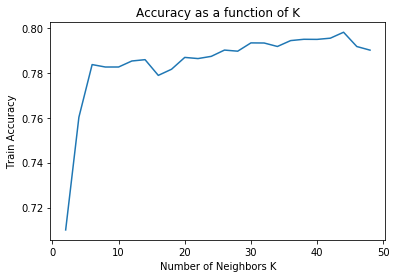

The optimal k value is 44


In [37]:
neighbors = list(filter(lambda x: x % 2 == 0, list(range(1,50))))
cv_scores = []

for kk in neighbors:
    knn = KNeighborsClassifier(n_neighbors=kk,n_jobs=-1,metric='braycurtis')
    scores = cross_val_score(knn, visual_words, train_labels, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_k = neighbors[cv_scores.index(max(cv_scores))]

plt.title('Accuracy as a function of K')
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Train Accuracy')
plt.show()
#python2.x
#print("The optimal k value is %d" % optimal_k)
#python3.x
print("The optimal k value is %d" % optimal_k)

We build a k-nn classifier and train it with the train descriptors

In [38]:
K_cv=3
folds = list(StratifiedKFold(n_splits=K_cv, shuffle=True, random_state=16).split(visual_words, train_labels))
for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)

    visual_words_train = visual_words[train_idx]
    train_labels=np.asarray(train_labels)
    labels_train = train_labels[train_idx]
    visual_words_valid = visual_words[test_idx]
    labels_valid= train_labels[test_idx]

    knn = KNeighborsClassifier(n_neighbors=optimal_k,n_jobs=-1,metric='braycurtis')
    knn.fit(visual_words_train, labels_train) 


===================FOLD= 0

===================FOLD= 1

===================FOLD= 2


We end up computing the test descriptors and compute the accuracy of the model

In [39]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    kpt,des=descriptors(gray,x)
        
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

In the next step we perform the confusion matrix to evaluate our classifier with respect the 8 image classes:

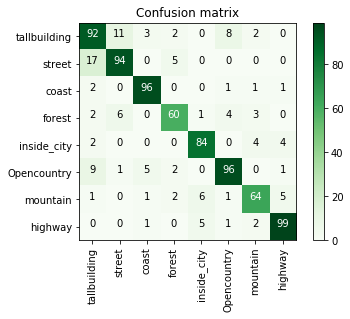

In [40]:
classes = list(set(test_labels))

if(Kernel== 'histogram'):
    predict= histogram_intersection(stdSlr_train.transform(visual_words_test),scaler_train)
    predictions= clf.predict(predict)
else:
    predictions= clf.predict(stdSlr_train.transform(visual_words_test))

conf_matrix= confusion_matrix(test_labels,predictions)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j],horizontalalignment="center",color="white" if conf_matrix[i, j] > thresh else "black")


In [41]:
#Provisional: I'm trying to perform more evaluation metrics

precision, recall, fscore, support= precision_recall_fscore_support(test_labels, predictions,average='macro')

print (precision*100)
print (recall*100)
print (fscore*100)

85.0998330275272
84.77954411689991
84.89924216239373


Finally, we compute the accuracy for SVM and KNN:

In [60]:
if Kernel == 'histogram':
    accuracy_svm = 100*clf.score(predict, test_labels)
else:
    accuracy_svm = 100*clf.score(stdSlr.transform(visual_words_test), test_labels)
print(accuracy_svm)

85.74969021065675


In [61]:
accuracy_knn = 100*knn.score(visual_words_test, test_labels)
print(accuracy_knn)

80.66914498141264


Finally, in the next tables we summarise all the results that we have obtained changing the different parameters and using different types of feature descriptors:

SIFT:

| Distance | Kbatch=128,Initial parameters | Kbatch=128,Optimal K |K=64,Initial parameters |
| --- | --- | --- | --- |
| Euclidean |  53.5315 | 55.8859 | 54.3990 |
| Chebyshev |  43.2465 | 44.6096 | 46.3444 |
| Manhattan |  50.1858 | 52.4163 | 53.4076 |
|  Hamming  |  35.1920 | 37.5464 | 38.16604|
| Canberra  |  50.1858 | 51.6728 | 49.0706 |
|Braycurtis |  57.1250 | 57.6208 | 54.7707 |

| Distance | Kbatch=64,Optimal K| Kbatch=256,Initial parameters | KBatch=256,Optimal K| 
| --- | --- | --- | --- |
| Euclidean | 54.0272 | 49.3184 | 49.5662 | 
| Chebyshev | 47.4597 | 42.1313 | 42.9987 |
| Manhattan | 53.7794 | 35.3159 | 35.4399 |
|  Hamming  | 42.5030 | 21.6852 | 23.1722 |
| Canberra  | 49.3184 | 47.5836 | 48.5749 | 
|Braycurtis | 55.0185 | 60.5947 | 61.2143 |

SURF:

| Distance | Kbatch=128,Initial parameters | Kbatch=128,Optimal K |K=64,Initial parameters |
| --- | --- | --- | --- |
| Euclidean |  54.7707 | 57.0012 | 58.8599 |
| Chebyshev |  46.8401 | 49.5662 | 52.1685 |
| Manhattan |  53.5315 | 53.5315 | 57.8686 |
|  Hamming  |  35.9355 | 37.1747 | 38.7856 |
| Canberra  |  55.7620 | 56.2577 | 56.7534 |
|Braycurtis |  62.5774 | 63.8166 | 61.8339 |

| Distance | Kbatch=64,Optimal K| Kbatch=256,Initial parameters | KBatch=256,Optimal K| 
| --- | --- | --- | --- |
| Euclidean | 58.6121 | 50.5576 | 50.5576 | 
| Chebyshev | 52.6641 | 47.4597 | 46.2205 |
| Manhattan | 59.1078 | 42.9987 | 43.2465 |
|  Hamming  | 40.6443 | 29.8636 | 31.1028 |
| Canberra  | 56.5055 | 52.4163 | 52.4163 |
|Braycurtis | 61.5861 | 63.5687 | 62.3296 |

ORB:

| Distance | Kbatch=128,Initial parameters | Kbatch=128,Optimal K |K=64,Initial parameters |
| --- | --- | --- | --- |
| Euclidean |  32.8376 | 36.4312 | 31.9702 |
| Chebyshev |  25.7744 | 27.7571 | 28.3767 |
| Manhattan |  33.2094 | 38.5377 | 32.4659 |
|  Hamming  |  26.0223 | 29.1201 | 24.4114 |
| Canberra  |  27.8810 | 30.6071 | 27.8810 |
|Braycurtis |  32.4659 | 32.4659 | 30.6071 |

| Distance | Kbatch=64,Optimal K| Kbatch=256,Initial parameters | KBatch=256,Optimal K| 
| --- | --- | --- | --- |
| Euclidean | 35.1920 | 34.6964 | 36.0594 | 
| Chebyshev | 26.2701 | 24.0396 | 23.7918 |
| Manhattan | 36.6790 | 27.8810 | 29.1201 |
|  Hamming  | 28.2527 | 20.8178 | 19.3308 |
| Canberra  | 30.8550 | 31.2267 | 33.3333 |
|Braycurtis | 31.2267 | 31.9702 | 31.2267 |

Dense SURF:

| Distance | Kbatch=128,Initial parameters | Kbatch=128,Optimal K |K=64,Initial parameters |
| --- | --- | --- | --- |
| Euclidean |  62.0817 | 63.9405 |61.8339|
| Chebyshev |  54.0272 | 54.1511 |57.8686|
| Manhattan |  64.9318 | 64.9318 |62.4535|
|  Hamming  |  42.0074 | 49.8141 |39.9008|
| Canberra  |  63.4448 | 63.9405 |63.8166|
|Braycurtis |  64.9318 | 65.1796 |62.8252|

| Distance | Kbatch=64,Optimal K| Kbatch=256,Initial parameters | KBatch=256,Optimal K| 
| --- | --- | --- | --- |
| Euclidean | 61.8339 | 64.6840 | 64.1883 | 
| Chebyshev | 57.8686 | 55.8859 | 52.5402 |
| Manhattan | 63.9405 | 67.4101 | 66.2949 |
|  Hamming  | 44.1140 | 50.8054 | 53.5315 |
| Canberra  | 64.1883 | 62.2057 | 63.4448 |
|Braycurtis | 63.5687 | 67.1623 | 66.4188 |

Dense SIFT:

| Distance | Kbatch=128,Initial parameters | Kbatch=128,Optimal K |K=64,Initial parameters |
| --- | --- | --- | --- |
| Euclidean |  70.1363 | 72.7385 | 69.7645 |
| Chebyshev |  58.7360 | 58.8599 | 58.9838 | 
| Manhattan |  76.7038 | 78.3147 | 73.3581 | 
|  Hamming  |  36.3073 | 38.6617 | 40.5204 |
| Canberra  |  74.2255 | 75.4646 | 71.1276 |
|Braycurtis |  76.7038 | 78.3147 | 73.6059 |

| Distance | Kbatch=64,Optimal K| Kbatch=256,Initial parameters | KBatch=256,Optimal K| 
| --- | --- | --- | --- |
| Euclidean | 73.1102  | 71.6232 | 71.3754 |
| Chebyshev | 62.7013  | 54.8946 | 53.5315 |
| Manhattan | 75.8364  | 79.9256 | 81.1648 |
|  Hamming  | 37.7942  | 36.9268 | 37.0508 |
| Canberra  | 74.1016  | 76.7038 | 78.0669 |
|Braycurtis | 75.8364  | 79.5539 | 81.0408 |














As we can see in our results, we have achieved to improve the initial acurracy of 53.53 almost 30% more. The best result is using the dense SIFT, a codebook size of 256 and the Manhattan (or Braycurtis 81.0408 %) distance where we obtain a 81.1648 % of accuracy.

During this first lab we can conclude that:

- Respect to the feature descriptors, we see a slightly improvement using SURF respect SIFT. Despite this, in the dense version we have the better results, specially, in dense SIFT. The ORB descriptor tends to get worse the results respect SIFT and SURF.

- Respect to the codebook size, we can see that using a size of 256 we achieved to slightly improve the accuracy.  However, the computational cost increase a lot at same time that we increase the size.

- Respect to the knn distance, from the 6 distances that we have tested, Braycurtis and Manhanttan distances provided us the best results. In the other hand, we have the Chebyshev and Hamming distance where we obtained the lowest accuracy.

- Respect to the number of neighbors, we can see that choosing the optimal k value the accuracy can increase until 5% more than using the initial parameter.







